In [6]:
from astropy.table import Table
import numpy as np
from ltsfit.ltsfit import ltsfit
from matplotlib import pyplot as plt
import corner
from utils import fit_plane, find_scatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
# load the GGL data tables with different sky areas of lenses bu galaxy population is on 10 deg^2
sky_area = "50.0v2"
GGL_data_table = Table.read(f"../data/GGL_{sky_area}_SQDEG_RED_DEFLECTOR_BLUE_SOURCE.fits", format='fits')
GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,stellar_mass_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0,1.1395730540197462,2.721757883923871,0.6383209474735921,234.52827079090258,408649665972.69635,25.933963738373834,26.127290551620234,26.254675998006924,25.877372770610663,25.77967242684352,22.98925557393261,24.057250718125182,25.178428704908463,22.13937039113474,21.469667400192904,0.5236284022464591,-0.2185177432823041,0.0403576488557333,0.22221328481968317,2,4.30707590221643,6033.914441400326,26.23568913352215
1,1.1676192009673254,2.838231941243875,0.5428598143754139,215.84729996869848,324309245490.47504,24.22762289989987,24.307252461915994,24.330966194829777,24.19614120355442,24.25840995562706,23.4402925996813,24.481996698219838,25.35590571629431,22.647451548717875,21.931126586377424,0.2833098895986966,0.01249637671998382,-0.11601750873715334,0.11668856741216427,2,2.339785570397245,9636.754519164577,25.086016539203026
2,0.8496635018062778,3.3535717429740073,0.641000768077548,198.8149905902349,252718868917.48575,25.559769535693853,25.692328159661358,26.0026527226674,25.435595481739007,25.34701222772341,21.96306329205506,22.827566278001065,23.54640956678392,21.2303460229086,20.962437814004915,0.23774477841756192,0.0316484729535937,0.16867423476209303,0.17161766608619294,2,1.820585794159507,9782.545548619119,22.86143073655398
3,1.5030247928909466,2.1037429248665225,0.5111993143704567,314.13299407421005,883777743495.4609,26.510924542753955,26.70858277146902,27.1583892110041,26.131180343134147,25.81278128068294,23.77862974498593,25.346268769963384,26.00807169213301,22.905058039418602,22.357811050847626,1.4659095665465913,-0.009356050373493305,-0.025632148189255435,0.027286309742933265,2,12.406290085901004,3755.908492949182,29.310824741747
4,0.09931798255962809,2.1700020122674757,0.8909096122755212,182.91937545558415,192914100798.88678,26.068800062516363,26.18260302373776,26.453438870162888,25.85431274554333,25.597538901622872,15.682406808159396,16.184348056972592,17.024734167739563,15.371562734687448,15.1519986272104,1.8882089102964354,-0.03149400430312179,0.020689174501004406,0.03768174954242524,2,3.4613724155333387,993.0878825186128,20.86717108100093
5,0.5288078808555957,4.343158907234654,1.8475198758908336,295.8237930636839,760108618473.295,26.489822086076952,26.713722342261637,27.968750435273822,26.51430656934446,26.36029223477607,18.820681063983304,19.673589738103377,20.940708005983755,18.453013637031862,18.219862227367084,1.3974704615046138,-0.037506289136146086,0.029683186537268865,0.04783109122496046,2,8.783981475448723,4329.28295528526,24.12990678858026
6,1.4559015868937206,3.8947692755843875,0.6865247003713678,244.97777562316497,462966940487.00793,26.6810933315858,26.722212903637512,27.36112014871479,26.47404290286856,26.398807903193074,24.046814542508628,25.29251052208788,25.617233245782813,23.347386960561984,22.7428989776878,0.3386182857665169,-0.03450844210644334,-0.04499833975555973,0.056706993901727315,2,2.862031469438829,11700.201951750312,25.745941106562977
7,0.2806689195320025,1.7410928677555793,0.702790233640981,178.45741656564877,176660221028.014,26.85810971732381,27.019893227146323,27.191141500680875,26.537720058873933,26.28112734684412,18.536060330766365,19.020192408396266,20.210660912850745,18.275044840954653,18.081439214360305,0.5836787330604735,-0.10351118102632655,-0.293874446056699,0.31157142783412706,2,2.481363853666704,2908.161559314505,21.745803937276175
8,0.7706303273274793,4.211551756362357,0.9218938814173087,225.27783876034175,365843003536.67883,26.207415223007033,26.463795844134502,27.56823350434354,26.10852487865217,25.982309600016222,21.08702338199977,22.261540879019485,23.52052383691099,20

In [8]:
# 1 year coadd
# point source depths: g < 26.0, r < 25.7, i < 25.0, z < 24.3, y < 23.1
# extended source depths are 1 mag shallower: g < 25.0, r < 24.7, i < 24.0, z < 23.3, y < 22.1
lsst_1_yr_coadd_mag_depth_mask = ((GGL_data_table['mag_D_g'] < 25.0) & (GGL_data_table['mag_S_g'] < 25.0) &
                        (GGL_data_table['mag_D_r'] < 24.7) & (GGL_data_table['mag_S_r'] < 24.7) &
                        (GGL_data_table['mag_D_i'] < 24.0) & (GGL_data_table['mag_S_i'] < 24.0) &
                        (GGL_data_table['mag_D_z'] < 23.3) & (GGL_data_table['mag_S_z'] < 23.3) &
                        (GGL_data_table['mag_D_y'] < 22.1) & (GGL_data_table['mag_S_y'] < 22.1)
                        # (GGL_data_table['z_S'] < 1.5) # 4MOST limit
)

# 10 year coadd
# point source depths: g < 27.4, r < 27.5, i < 26.8, z < 26.1, y < 24.9
# extended source depths are 1 mag shallower: g < 26.4, r < 26.5, i < 25.8, z < 25.1, y < 23.9
lsst_10_yr_coadd_mag_depth_mask = ((GGL_data_table['mag_D_g'] < 26.4) & (GGL_data_table['mag_S_g'] < 26.4) &
                        (GGL_data_table['mag_D_r'] < 26.5) & (GGL_data_table['mag_S_r'] < 26.5) &
                        (GGL_data_table['mag_D_i'] < 25.8) & (GGL_data_table['mag_S_i'] < 25.8) &
                        (GGL_data_table['mag_D_z'] < 25.1) & (GGL_data_table['mag_S_z'] < 25.1) &
                        (GGL_data_table['mag_D_y'] < 23.9) & (GGL_data_table['mag_S_y'] < 23.9)
                        # (GGL_data_table['z_S'] < 1.5) # 4MOST limit
)

# 4MOST spec-z for sources: r < 23.5 and z < 1.5

lsst_4MOST_mag_depth_mask = (
                        (GGL_data_table['mag_D_r'] < 23.5) & (GGL_data_table['mag_S_r'] < 23.5) &
                        (GGL_data_table['z_S'] < 1.5) # 4MOST limit
)

print('----------------------------------')
print("Sky area:", 50, "deg^2")
print('----------------------------------')
print("Y1 # lenses:", np.sum(lsst_1_yr_coadd_mag_depth_mask))
print("Y10 # lenses:", np.sum(lsst_10_yr_coadd_mag_depth_mask))
print("4MOST # lenses:", np.sum(lsst_4MOST_mag_depth_mask))
print('----------------------------------')
print()
print('----------------------------------')
print("Sky area:", 20000, "deg^2")
print('----------------------------------')
print("Y1 # lenses:", np.sum(lsst_1_yr_coadd_mag_depth_mask)*20000/50)
print("Y10 # lenses:", np.sum(lsst_10_yr_coadd_mag_depth_mask)*20000/50)
print("4MOST # lenses:", np.sum(lsst_4MOST_mag_depth_mask)*20000/50)
print('----------------------------------')

----------------------------------
Sky area: 50 deg^2
----------------------------------
Y1 # lenses: 26
Y10 # lenses: 355
4MOST # lenses: 26
----------------------------------

----------------------------------
Sky area: 20000 deg^2
----------------------------------
Y1 # lenses: 10400.0
Y10 # lenses: 142000.0
4MOST # lenses: 10400.0
----------------------------------


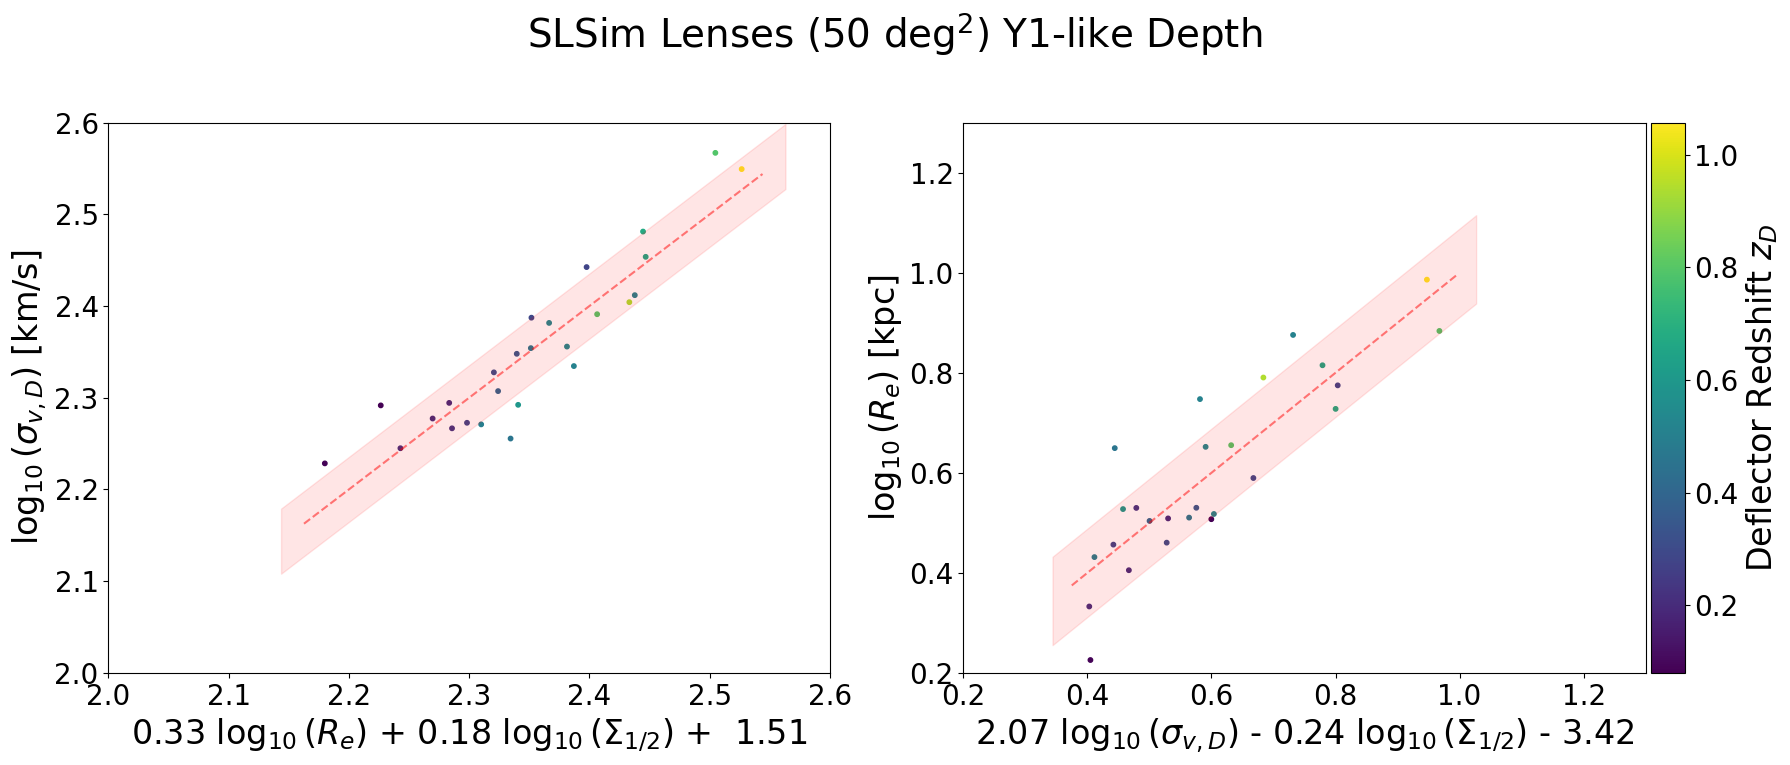

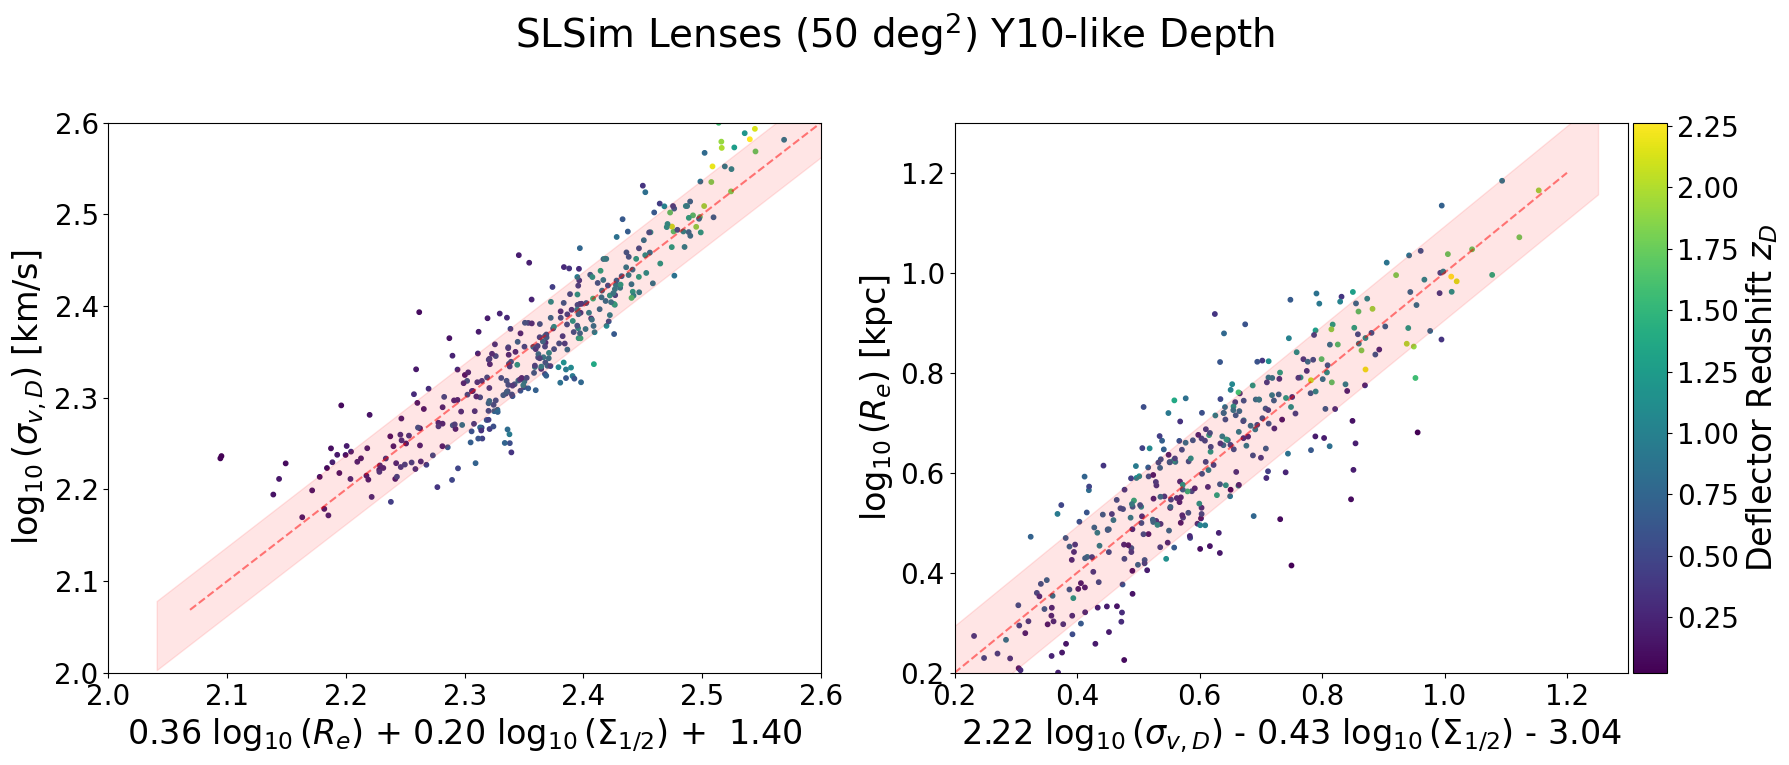

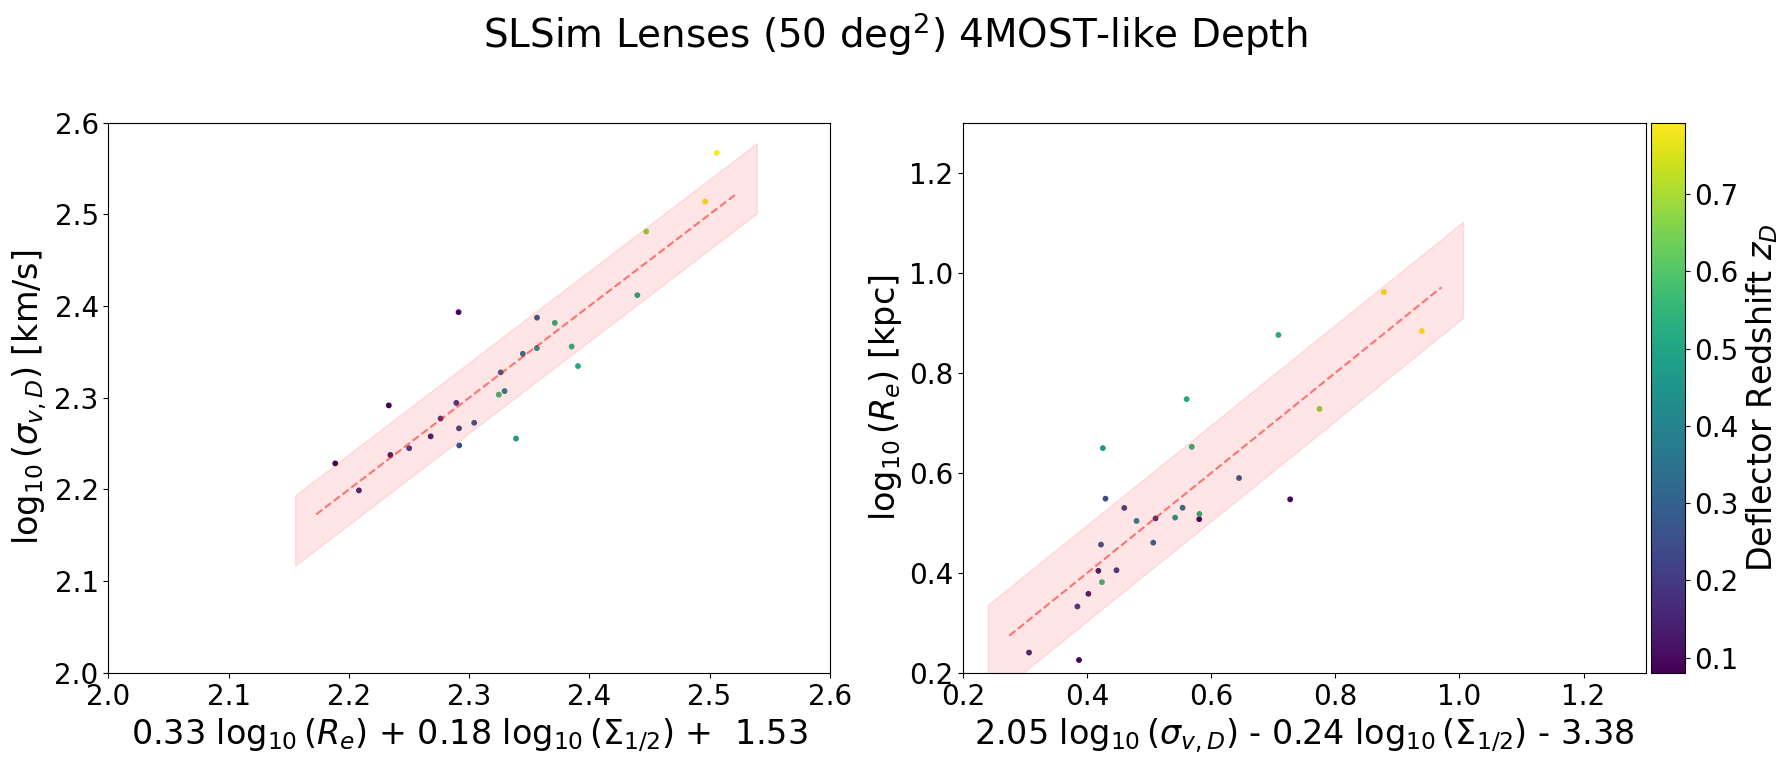

In [10]:
# MFP for the original data at different depths

title_list = [
    "SLSim Lenses (50 deg$^2$) Y1-like Depth",
    "SLSim Lenses (50 deg$^2$) Y10-like Depth",
    "SLSim Lenses (50 deg$^2$) 4MOST-like Depth",
]
i = 0
for data_table in [GGL_data_table[lsst_1_yr_coadd_mag_depth_mask],
                   GGL_data_table[lsst_10_yr_coadd_mag_depth_mask],
                   GGL_data_table[lsst_4MOST_mag_depth_mask]]:
    # fit the MFP
    coeffs_MFP = fit_plane(
        np.log10(data_table["R_e_kpc"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["sigma_v_D"])
    )

    # find the scatter
    scatter_MFP = find_scatter(
        np.log10(data_table["R_e_kpc"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["sigma_v_D"]),
        coeffs_MFP,
        return_fit=False
    )

    # fit the MFP with R_e as the dependent variable
    coeffs_MFP_alt = fit_plane(
        np.log10(data_table["sigma_v_D"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["R_e_kpc"])
    )

    # find the scatter
    scatter_MFP_alt = find_scatter(
        np.log10(data_table["sigma_v_D"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["R_e_kpc"]),
        coeffs_MFP_alt,
        return_fit=False
    )

    # side-by-side plot of the two fundamental planes
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    # sigma_v fundamental plane
    axs[0].scatter(
        coeffs_MFP[0] * np.log10(data_table["R_e_kpc"]) + 
        coeffs_MFP[1] * np.log10(data_table["Sigma_half_Msun/pc2"]) + 
        coeffs_MFP[2],
        np.log10(data_table["sigma_v_D"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[0].set_xlabel(f'{coeffs_MFP[0]:.2f} ' + r'$\log_{10}(R_e)$ + ' + f'{coeffs_MFP[1]:.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ + ' + f' {coeffs_MFP[2]:.2f}')
    axs[0].set_ylabel(r'$\log_{10}(\sigma_{v, D})$ [km/s]')
    # axs[0].set_title('SLSim Mass Fundamental Plane', fontsize=16)

    # Plot the fitted plane with a faded scatter
    # y = x
    axs[0].plot([axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                [axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[0].get_xlim()[0], axs[0].get_xlim()[1], 100)
    y_faded = x_faded
    axs[0].fill_between(x_faded, y_faded - np.std(scatter_MFP),
                        y_faded + np.std(scatter_MFP), color='red', alpha=0.1)

    # R_e fundamental plane
    scatter_plot = axs[1].scatter(
        coeffs_MFP_alt[0] * np.log10(data_table["sigma_v_D"]) + 
        coeffs_MFP_alt[1] * np.log10(data_table["Sigma_half_Msun/pc2"]) + 
        coeffs_MFP_alt[2],
        np.log10(data_table["R_e_kpc"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[1].set_xlabel(f'{coeffs_MFP_alt[0]:.2f} ' + r'$\log_{10}(\sigma_{v, D})$ ' + f'{'+' if coeffs_MFP_alt[1] > 0 else '-'} {np.abs(coeffs_MFP_alt[1]):.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ ' + f'{'+' if coeffs_MFP_alt[2] > 0 else '-'} {np.abs(coeffs_MFP_alt[2]):.2f}')
    axs[1].set_ylabel(r'$\log_{10}(R_e)$ [kpc]')
    # axs[1].set_title('SLSim Mass Fundamental Plane', fontsize=16)
    # Plot the fitted plane with a faded scatter
    # y = x
    axs[1].plot([axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                [axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[1].get_xlim()[0], axs[1].get_xlim()[1], 100)
    y_faded = x_faded
    axs[1].fill_between(x_faded, y_faded - np.std(scatter_MFP_alt),
                        y_faded + np.std(scatter_MFP_alt), color='red', alpha=0.1)

    # common colorbar
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(scatter_plot, cax=cax)
    cbar.set_label('Deflector Redshift $z_D$', fontsize=14)


    # increase the font size of the labels and title
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_xlabel(ax.get_xlabel(), fontsize=24)
        ax.set_ylabel(ax.get_ylabel(), fontsize=24)
        ax.set_title(ax.get_title(), fontsize=24)
        # ax.legend(fontsize=14)

    # cbar label size
    cbar.ax.set_ylabel(cbar.ax.get_ylabel(), fontsize=24)

    # cbar tick labels
    cbar.ax.tick_params(labelsize=20)

    axs[0].set_xlim(2, 2.6)
    axs[0].set_ylim(2, 2.6)
    axs[1].set_xlim(0.2, 1.3)
    axs[1].set_ylim(0.2, 1.3)

    fig.suptitle(title_list[i], fontsize=28)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    i += 1

# save the figure
# fig.savefig(f"../figures/slsim_MFP.pdf", bbox_inches='tight', dpi=300)

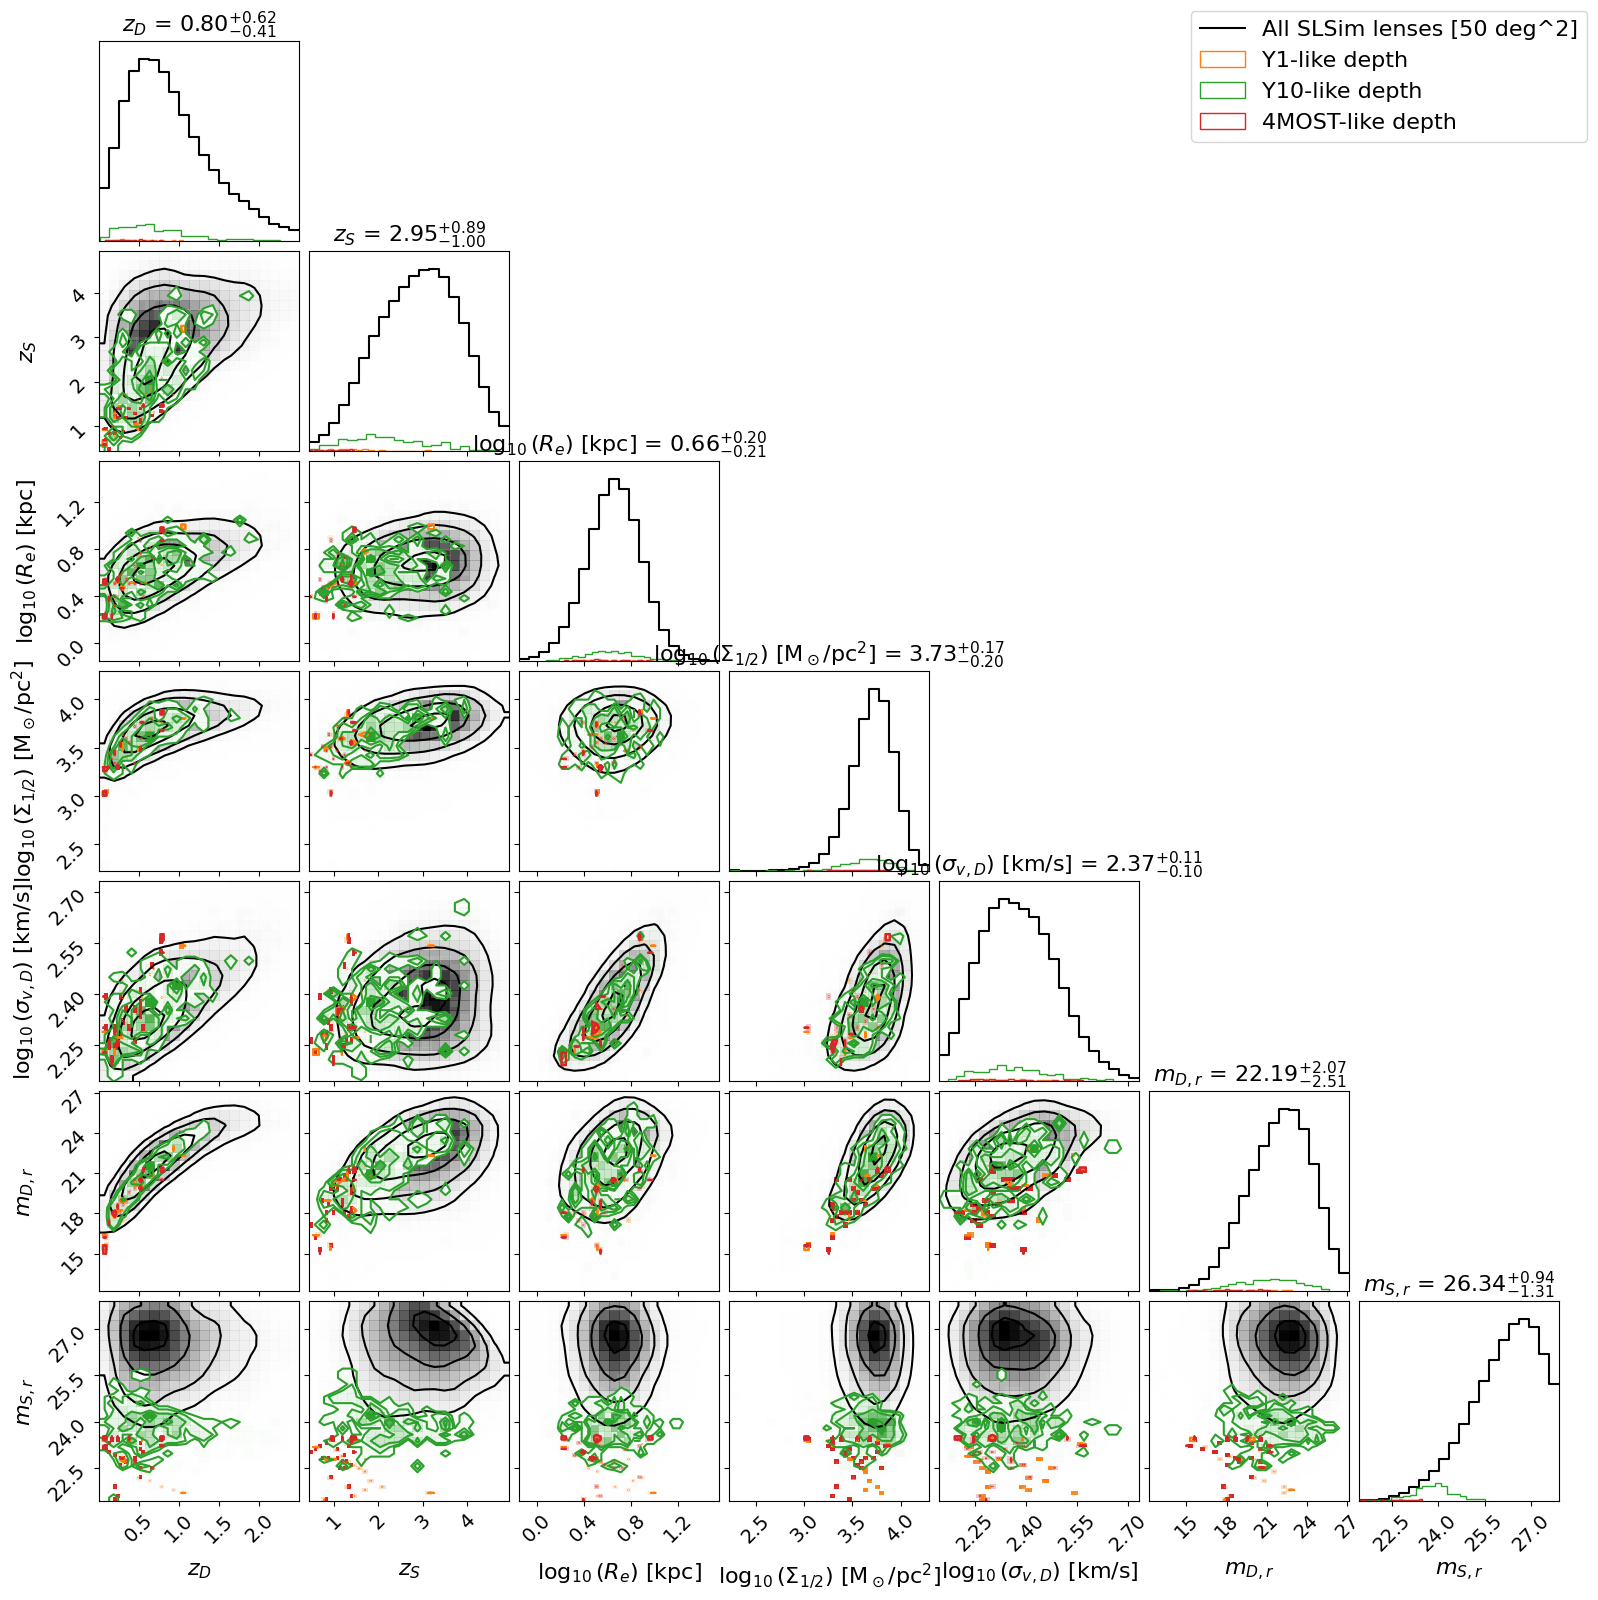

In [17]:
#### Make corner plot of the Original and 3 depth cut data sets
key_list = ['z_D',
            'z_S',
            'log_R_e_kpc', 
            'log_Sigma_half_Msun/pc2', 
            'log_sigma_v_D', 
            'mag_D_r', 
            'mag_S_r']
key_latex_labels = {
    'z_D': r'$z_D$',
    'z_S': r'$z_S$',
    'log_R_e_kpc': r'$\log_{10}(R_e)$ [kpc]',
    'log_Sigma_half_Msun/pc2': r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]',
    'log_sigma_v_D': r'$\log_{10}(\sigma_{v, D})$ [km/s]',
    'mag_D_r': r'$m_{D, r}$',
    'mag_S_r': r'$m_{S, r}$'
}

GGL_data_table['log_R_e_kpc'] = np.log10(GGL_data_table['R_e_kpc'])
GGL_data_table['log_Sigma_half_Msun/pc2'] = np.log10(GGL_data_table['Sigma_half_Msun/pc2'])
GGL_data_table['log_sigma_v_D'] = np.log10(GGL_data_table['sigma_v_D'])

data_corner = [GGL_data_table[key] for key in key_list]
data_corner = np.array(data_corner).T

data_corner_Y1 = [GGL_data_table[lsst_1_yr_coadd_mag_depth_mask][key] for key in key_list]
data_corner_Y1 = np.array(data_corner_Y1).T

data_corner_Y10 = [GGL_data_table[lsst_10_yr_coadd_mag_depth_mask][key] for key in key_list]
data_corner_Y10 = np.array(data_corner_Y10).T

data_corner_4MOST = [GGL_data_table[lsst_4MOST_mag_depth_mask][key] for key in key_list]
data_corner_4MOST = np.array(data_corner_4MOST).T

fig_corner = corner.corner(
    data_corner,
    labels=[key_latex_labels[key] for key in key_list],
    show_titles=True,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
);

corner.corner(
    data_corner_Y1,
    labels=[key_latex_labels[key] for key in key_list],
    color='C1',
    fig=fig_corner,
    plot_datapoints=False,
);

corner.corner(
    data_corner_Y10,
    labels=[key_latex_labels[key] for key in key_list],
    color='C2',
    fig=fig_corner,
    plot_datapoints=False,
);

corner.corner(
    data_corner_4MOST,
    labels=[key_latex_labels[key] for key in key_list],
    color='C3',
    fig=fig_corner,
    plot_datapoints=False,
);

fig_corner.legend(
    ['All SLSim lenses [50 deg^2]', 'Y1-like depth', 'Y10-like depth', '4MOST-like depth'],
    loc='upper right',
    fontsize=16
)

# make the font size of the labels and titles larger
for ax in fig_corner.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=16)